In [2]:
from collections import defaultdict

import numpy as np
import torch
import torch.nn.functional as F

from monopoly_go import monopoly_go_v0
from dqn import DQN, ReplayBuffer
import matplotlib.pyplot as plt

device = torch.device("mps")

# Hyperparameters
num_episodes = 10000
gamma = 0.99
epsilon = 1
epsilon_decay = 0.999
epsilon_min = 0.1
batch_size = 128
lr = 1e-6
target_update_freq = 50

# Environment setup
env = monopoly_go_v0.env(render_mode="human")
env.reset()
sample_obs = env.observe("player_0")
obs_size = sample_obs.shape[0]
action_size = env.action_space("player_0").n

# Model + target
policy_net = DQN(obs_size, action_size).to(device)
target_net = DQN(obs_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
buffer = ReplayBuffer()

agent_to_train = "player_0"


In [3]:
winners = [0, 0, 0]

total_action_counts = {"player_0": defaultdict(int),
                       "player_1": defaultdict(int),
                       "player_2": defaultdict(int)}
total_action_avails = {"player_0": defaultdict(int),
                       "player_1": defaultdict(int),
                       "player_2": defaultdict(int)}

losses = []
average_losses = []
wins = 0
win_rates = []
rewards = []
average_rewards = []
terminated = [False] * 3
exploration_eps = 3000
for ep in range(num_episodes):
    env = monopoly_go_v0.env(render_mode="human")
    env.reset()
    last_obs = {}
    if ep < exploration_eps//2:
        env.all_bankable = False
    else:
        env.all_bankable = True
    env.shaped = True

    while True:
        agent = env.agent_selection
        obs, reward, term, trunc, info = env.last()

        if term:
            terminated[env.curr_agent_index] = True
            env.step(None)

        if not term and agent == agent_to_train:
            # ε-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space(agent).sample(info["action_mask"])
                action_mask = info["action_mask"]
            else:
                with torch.no_grad():
                    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
                    q_values = policy_net(obs_tensor)
                    orig_q_values = q_values
                    mask = torch.tensor(info["action_mask"], dtype=torch.bool).unsqueeze(0)  # shape [1, 611]
                    assert mask.sum() > 0, "All actions masked — bug in masking logic"
                    q_values[~mask] = -float('inf')
                    action = torch.argmax(q_values).item()

            last_obs[agent] = obs
            last_action = action
        else:
            action = env.action_space(agent).sample(info["action_mask"])

        env.step(action if not term else None)

        if agent == agent_to_train:
            next_obs, r, done_flag, _, _ = env.last()
            rewards.append(r)
            if len(rewards) == 5000:
                average_rewards.append(np.mean(rewards))
                rewards = []
            buffer.add((last_obs[agent], last_action, r, next_obs, done_flag))

        if all(terminated):
            terminated = [False] * 3
            break
    
    if env.winner >= 0 and ep >= exploration_eps:
        if env.winner == 0:
            wins += 1
        winners[env.winner] += 1

    if ep and ep % 100 == 0 and ep >= exploration_eps:
        win_rates.append(wins/100)
        wins = 0
    
    if ep >= exploration_eps:
        for agent in env.action_counts:
            for action in env.action_counts[agent]:
                total_action_counts[agent][action] += env.action_counts[agent][action]
            for action in env.action_availabilities[agent]:
                total_action_avails[agent][action] += env.action_availabilities[agent][action]

    # Training step
    if len(buffer.buffer) >= batch_size:
        obs_b, act_b, rew_b, next_obs_b, done_b = buffer.sample(batch_size, device=device)
        obs_b = obs_b.float().to(device)
        act_b = act_b.long().to(device)
        rew_b = rew_b.float().to(device)
        next_obs_b = next_obs_b.float().to(device)
        done_b = done_b.float().to(device)

        q_vals = policy_net(obs_b).gather(1, act_b.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_vals = target_net(next_obs_b).max(1)[0]
            target = rew_b + gamma * next_q_vals * (1 - done_b)

        loss = F.mse_loss(q_vals, target)
        losses.append(loss.item())
        if len(losses) == 100:
            average_losses.append(np.mean(losses))
            losses = []
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Decay epsilon
    if ep >= exploration_eps:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
    # Update target network
    if ep % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if ep and ep % 100 == 0:
        print(f"Episode {ep} done. ε={epsilon:.3f}")
        if win_rates:
            print(f"Latest win rate: {win_rates[-1]}")
        if average_rewards:
            print(f"Latest average reward: {average_rewards[-1]}")
        if average_losses:
            print(f"Latest average loss: {average_losses[-1]}")

Episode 100 done. ε=1.000
Latest average reward: -3.1878
Episode 200 done. ε=1.000
Latest average reward: -2.9884
Latest average loss: 1295.7688024902343
Episode 300 done. ε=1.000
Latest average reward: -3.2954
Latest average loss: 1270.1434814453125
Episode 400 done. ε=1.000
Latest average reward: -3.3258
Latest average loss: 1241.2589990234376
Episode 500 done. ε=1.000
Latest average reward: -3.1368
Latest average loss: 1255.916221923828
Episode 600 done. ε=1.000
Latest average reward: -3.1274
Latest average loss: 1227.7982238769532
Episode 700 done. ε=1.000
Latest average reward: -3.3872
Latest average loss: 1209.7955847167968
Episode 800 done. ε=1.000
Latest average reward: -3.039
Latest average loss: 1197.2491198730468
Episode 900 done. ε=1.000
Latest average reward: -3.274
Latest average loss: 1173.0875134277344
Episode 1000 done. ε=1.000
Latest average reward: -3.1516
Latest average loss: 1168.5257562255858
Episode 1100 done. ε=1.000
Latest average reward: -3.4132
Latest average

KeyboardInterrupt: 

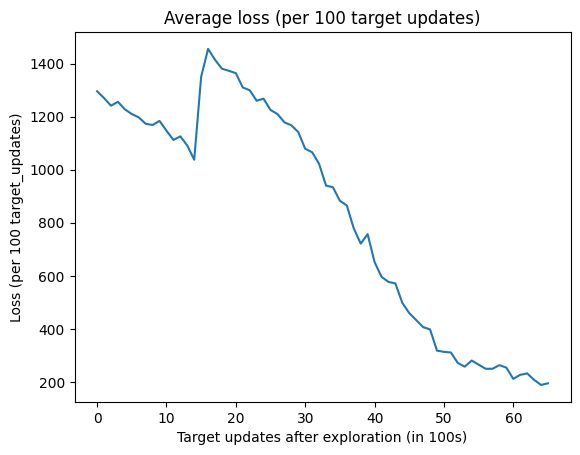

In [4]:
plt.xlabel("Target updates after exploration (in 100s)")
plt.ylabel("Loss (per 100 target_updates)")
plt.title("Average loss (per 100 target updates)")
plt.plot(average_losses)

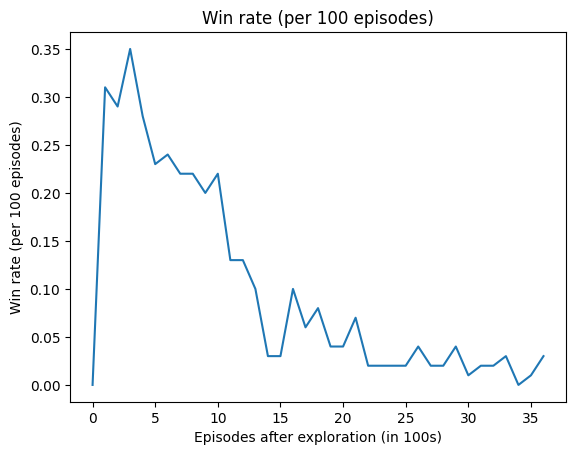

In [5]:
plt.xlabel("Episodes after exploration (in 100s)")
plt.ylabel("Win rate (per 100 episodes)")
plt.title("Win rate (per 100 episodes)")
plt.plot(win_rates)

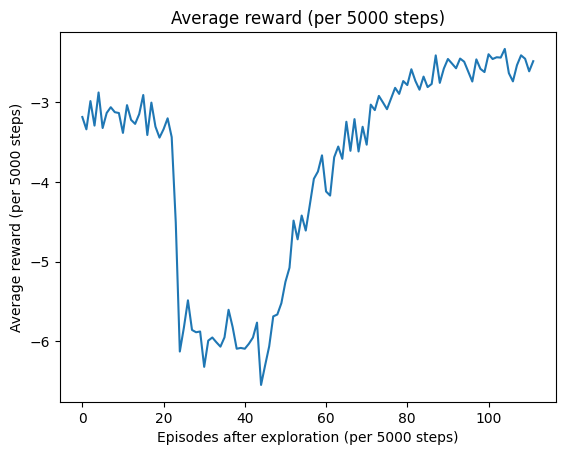

In [6]:
plt.xlabel("Episodes after exploration (per 5000 steps)")
plt.ylabel("Average reward (per 5000 steps)")
plt.title("Average reward (per 5000 steps)")
plt.plot(average_rewards)

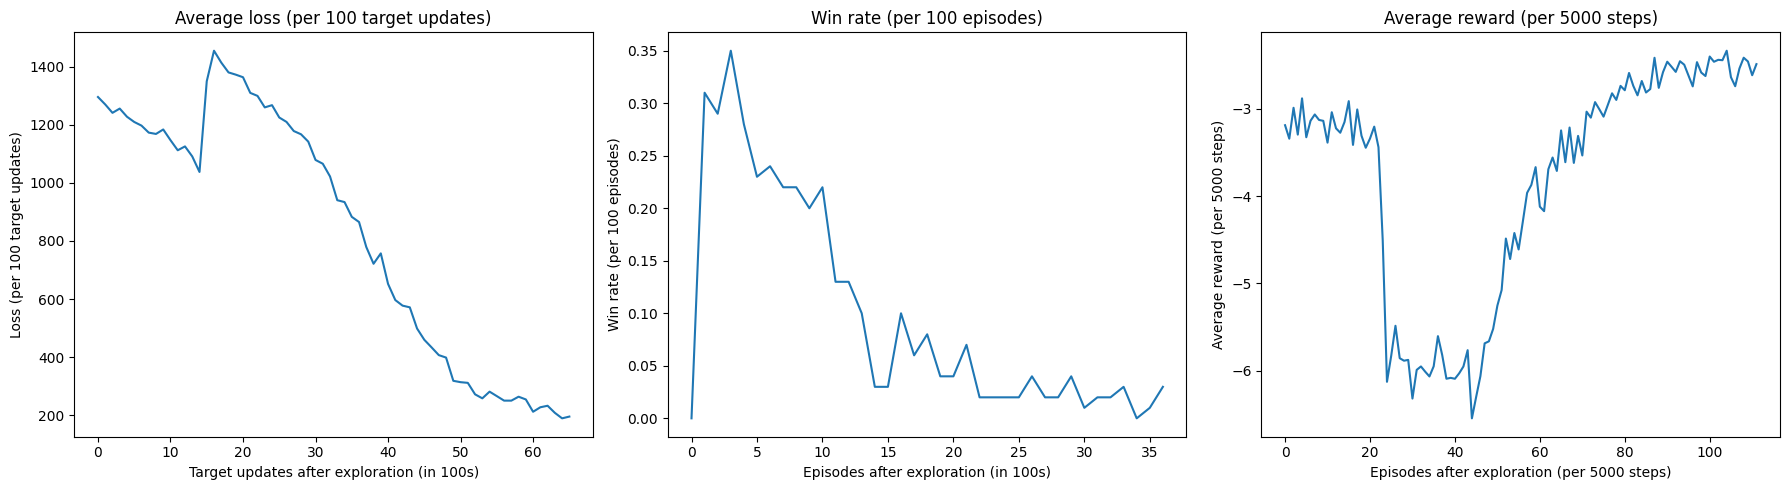

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(18, 5))  # 3 plots side-by-side

# --- Loss Plot ---
axes[0].set_xlabel("Target updates after exploration (in 100s)")
axes[0].set_ylabel("Loss (per 100 target updates)")
axes[0].set_title("Average loss (per 100 target updates)")
axes[0].plot(average_losses)

# --- Win Rate Plot ---
axes[1].set_xlabel("Episodes after exploration (in 100s)")
axes[1].set_ylabel("Win rate (per 100 episodes)")
axes[1].set_title("Win rate (per 100 episodes)")
axes[1].plot(win_rates)

# --- Reward Plot ---
# If average_rewards is per-agent dict, flatten or pick one agent to plot
if isinstance(average_rewards, dict):
    agent_id = "player_0"  # or any other key
    reward_data = average_rewards[agent_id]
else:
    reward_data = average_rewards

axes[2].set_xlabel("Episodes after exploration (per 5000 steps)")
axes[2].set_ylabel("Average reward (per 5000 steps)")
axes[2].set_title("Average reward (per 5000 steps)")
axes[2].plot(reward_data)

plt.tight_layout()
plt.show()


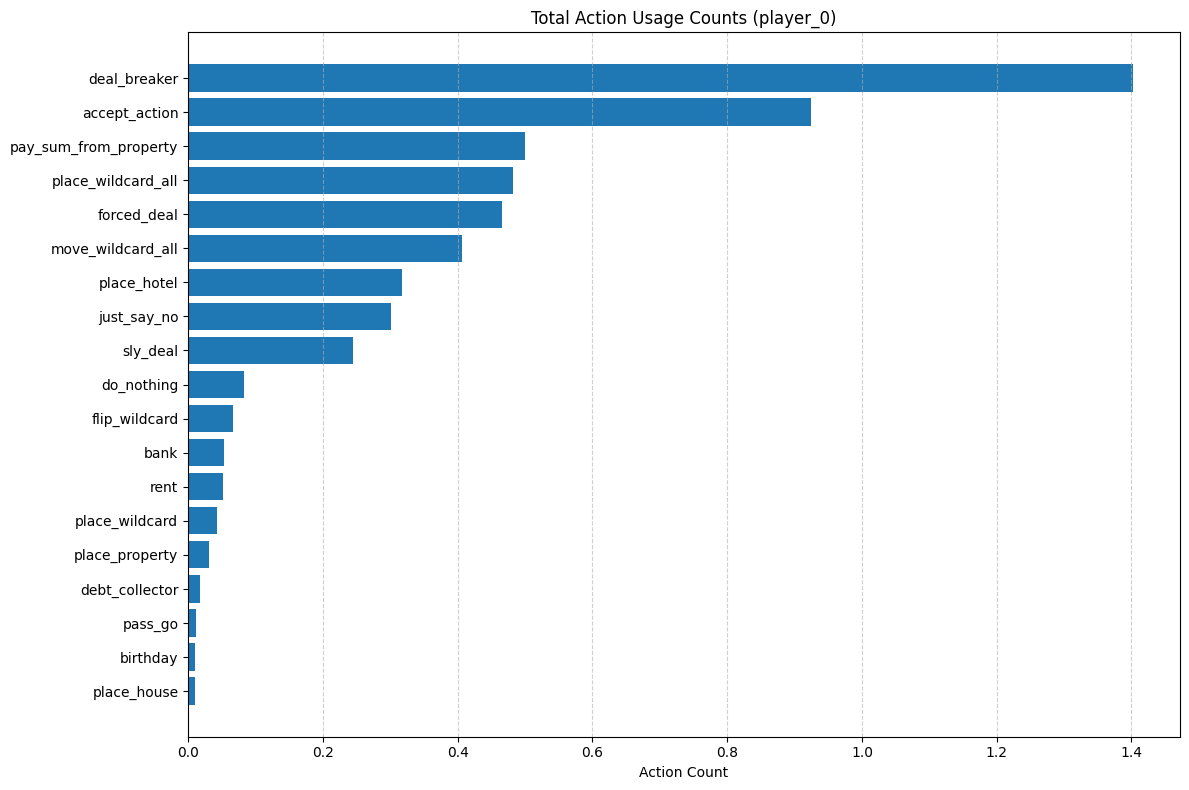

In [8]:
actions, counts = zip(*sorted(total_action_counts["player_0"].items(), key=lambda x: x[1], reverse=True))

rel_actions = []
rel_counts = []
for a, c in zip(actions, counts):
    if a in total_action_avails["player_0"]:
        rel_actions.append(a)
        rel_counts.append(total_action_counts["player_0"][a]/total_action_avails["player_0"][a])

rel_actions, rel_counts = zip(*sorted(zip(rel_actions, rel_counts), reverse=True, key=lambda x: x[1]))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(rel_actions, rel_counts)
plt.xlabel("Action Count")
plt.title("Total Action Usage Counts (player_0)")
plt.gca().invert_yaxis()  # Most frequent action at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
print(total_action_counts["player_0"])
print(total_action_avails["player_0"])

defaultdict(<class 'int'>, {'place_property': 19629, 'bank': 55149, 'just_say_no': 649, 'do_nothing': 10486, 'accept_action': 55033, 'deal_breaker': 27162, 'forced_deal': 9660, 'move_wildcard_all': 58360, 'place_wildcard': 9846, 'rent': 14590, 'place_wildcard_all': 2648, 'discard_card': 35208, 'sly_deal': 8382, 'flip_wildcard': 16064, 'birthday': 2332, 'pass_go': 2586, 'debt_collector': 5670, 'place_house': 419, 'place_hotel': 332, 'pay_sum_from_property': 2398})
defaultdict(<class 'int'>, {'place_property': 1028158, 'pass_go': 161358, 'bank': 346451, 'do_nothing': 363931, 'just_say_no': 2088, 'accept_action': 56455, 'sly_deal': 22300, 'rent': 354002, 'birthday': 94252, 'deal_breaker': 21283, 'forced_deal': 16889, 'move_wildcard_all': 170945, 'place_wildcard': 173768, 'flip_wildcard': 546064, 'place_wildcard_all': 3878, 'forced_action': 70320, 'debt_collector': 28511, 'place_house': 57525, 'place_hotel': 21363, 'pay_sum_from_property': 4799})


In [16]:
for a, c in zip(rel_actions, rel_counts):
    print(f"{a}: {c}")

accept_action: 0.9044111492424877
just_say_no: 0.6452296819787986
pay_sum_from_property: 0.5
forced_deal: 0.4988936170212766
place_wildcard_all: 0.36140724946695096
sly_deal: 0.3096964813322589
move_wildcard_all: 0.28358487485129114
bank: 0.16568136504845365
debt_collector: 0.12259457429831973
rent: 0.05254336520910583
do_nothing: 0.05071421289321356
place_wildcard: 0.0419319022945966
place_property: 0.039335153569114066
birthday: 0.03285130462118831
flip_wildcard: 0.032600997780960324
place_house: 0.030142781597038603
deal_breaker: 0.029307909604519775
place_hotel: 0.022328548644338118
pass_go: 0.021524101421008638


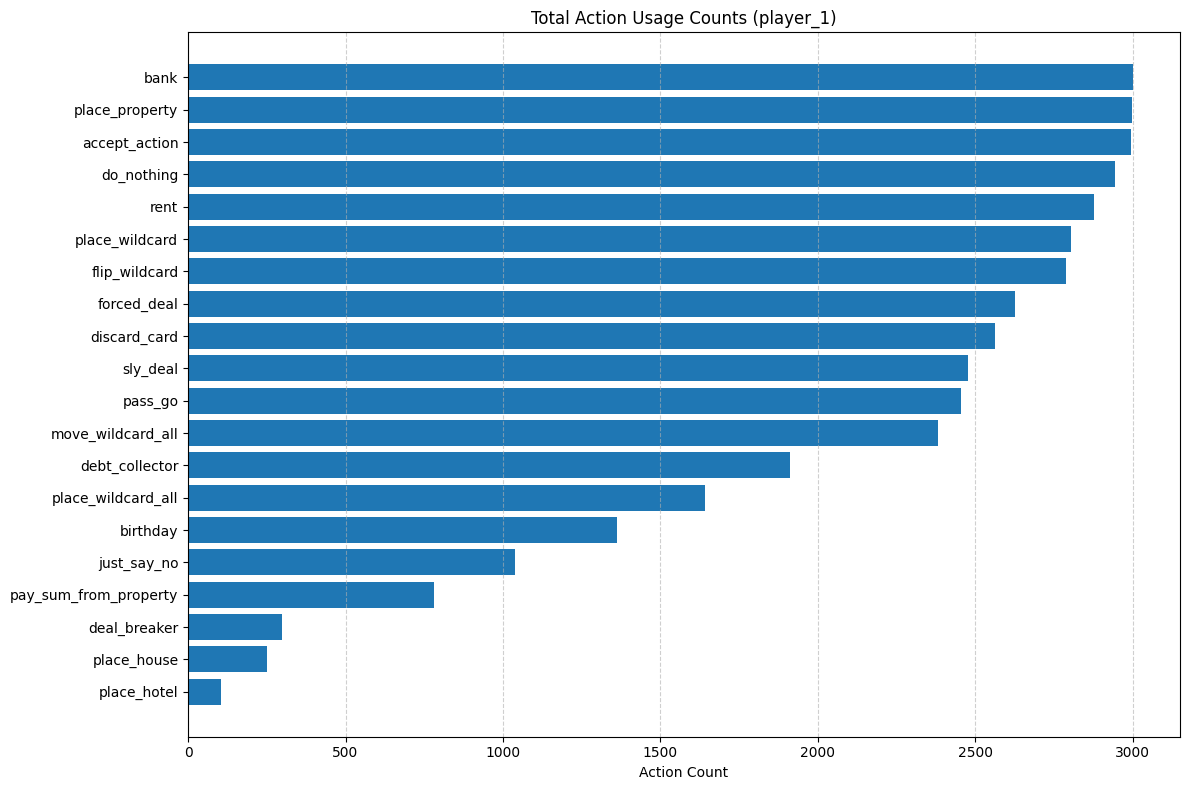

In [8]:
actions, counts = zip(*sorted(total_action_counts["player_1"].items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(actions, counts)
plt.xlabel("Action Count")
plt.title("Total Action Usage Counts (player_1)")
plt.gca().invert_yaxis()  # Most frequent action at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


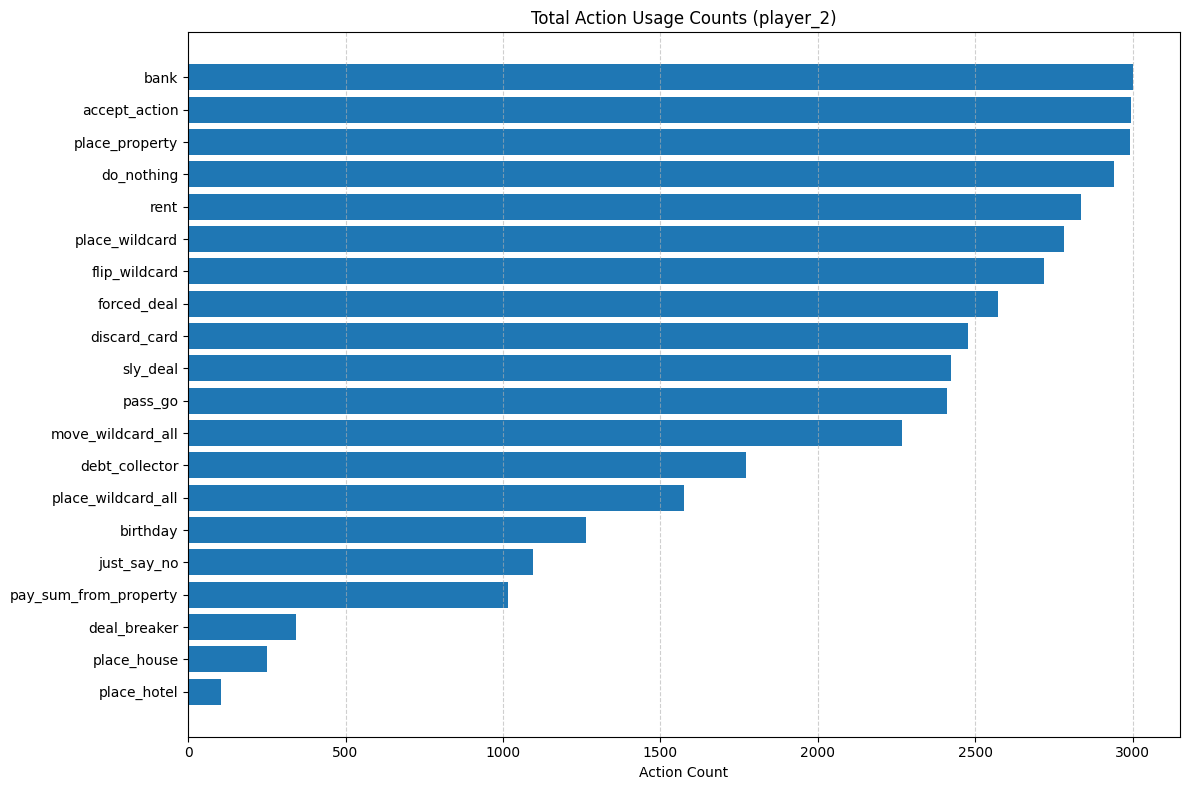

In [9]:
actions, counts = zip(*sorted(total_action_counts["player_2"].items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(actions, counts)
plt.xlabel("Action Count")
plt.title("Total Action Usage Counts (player_2)")
plt.gca().invert_yaxis()  # Most frequent action at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()